# (04) ROFL: pathological examples?

**Motivation**: Some examples explored in ROFL. Conclusion: we really need to set the correct stats.

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def compute_mu_sd(x, axis: int = 0):
    mu = x.mean(axis, keepdims=True)
    sd = x.std(axis, keepdims=True)
    return mu, sd


from analysis.opticflow import ROFL, Obj, _replace_z
from analysis.linear import mi_analysis

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

## Load

In [3]:
# skip + x
# model_name = 'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)'
# fit_name = 'ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_24,18:00)'

# skip + 0.1 * x
model_name = 'fixate1_k-32_z-14x[5,10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'skip+0.1x_ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_05_30,09:01)'

tr, meta = load_model(
    model_name=model_name,
    fit_name=fit_name,
    verbose=False,
    device='cuda',
    shuffle=False,
)

### Lin Reg

In [4]:
%%time

g, select_lbl = prep_rofl(
    labels=list(LBL2TEX) + [
        'slf_v_norm',
        'slf_v_theta',
        'slf_v_phi']
)
z = {
    k: tr.forward(k, True)[0]['z']
    for k in g
}

CPU times: user 6min 37s, sys: 2min 2s, total: 8min 40s
Wall time: 8min 40s


In [5]:
mu_sd = {
    'g': compute_mu_sd(np.concatenate(
        [v for v in g.values()])),
    'z': compute_mu_sd(np.concatenate(
        [v for v in z.values()])),
}

In [6]:
idx = 6
idx, select_lbl[idx]

(6, 'obj0_alpha_y')

In [7]:
lr = sk_linear.LinearRegression().fit(
    shift_rescale(z['trn'], *mu_sd['z']),
    shift_rescale(g['trn'], *mu_sd['g'])[:, idx],
)
pred = lr.predict(shift_rescale(np.concatenate(
    [z['vld'], z['tst']]), *mu_sd['z']))
true = shift_rescale(np.concatenate(
    [g['vld'], g['tst']]), *mu_sd['g'])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.925726033402866

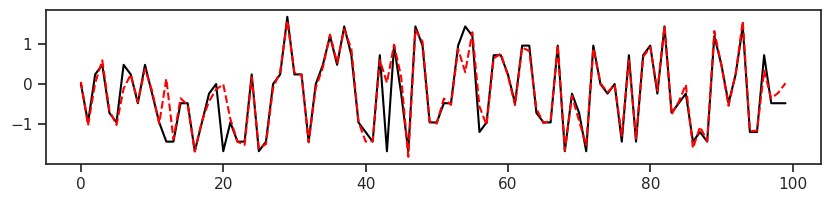

In [8]:
fig, ax = create_figure(1, 1, (10, 2))
ax.plot(true[:100], 'k')
ax.plot(pred[:100], 'r--')
plt.show()

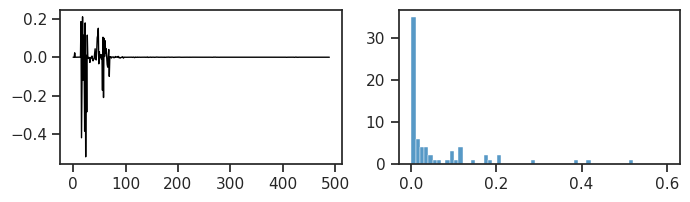

In [9]:
u_hat = lr.coef_ / sp_lin.norm(lr.coef_)

fig, axes = create_figure(1, 2, (8, 2))
axes[0].plot(u_hat, lw=1, color='k')
sns.histplot(np.abs(u_hat), bins=np.linspace(0.001, 0.6 + 0.001, 61), ax=axes[1])
axes[1].set_ylabel('')
plt.show()

## ROFL test

In [3]:
kws = dict(
    category='fixate',
    n_obj=1,
    dim=17,
    fov=45.0,
    obj_r=0.25,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 3.5

{
    'category': 'fixate',
    'n_obj': 1,
    'dim': 17,
    'fov': 45.0,
    'obj_r': 0.25,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [4]:
n = 1000
rofl = ROFL(n=n, **kws)

In [5]:
rofl.compute_coords().compute_flow()
accept = rofl.filter(min_obj_size)
accept.sum() / rofl.n

0.88

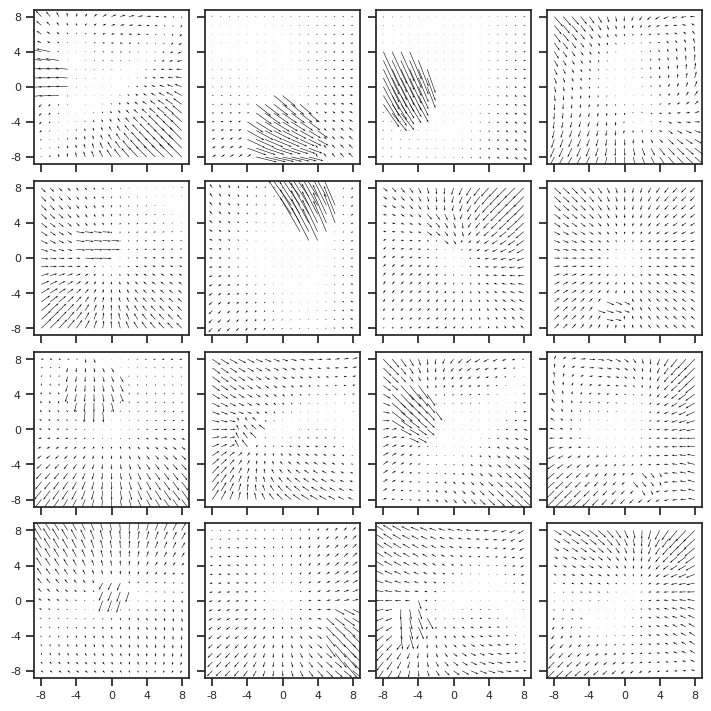

In [6]:
show_opticflow(rofl.alpha_dot[accept]);

In [7]:
attrs_slf = {
    k: getattr(rofl, k) for
    k in ['fix', 'v_slf']
}
alpha = rofl.objects[0].alpha.copy()
alpha[:, 1] = [rofl.span[8]] * rofl.n
attrs_obj = {0: {
    'alpha': alpha,
    'v_obj': rofl.objects[0].v,
    'z': rofl.objects[0].pos[:, 2],
}}

rofl_new = ROFL(n=rofl.n, **kws)
rofl_new.setattrs(attrs_slf, attrs_obj)
_ = rofl_new.compute_flow()
accept = rofl_new.filter(min_obj_size)

In [8]:
accept.sum() / rofl_new.n

0.942

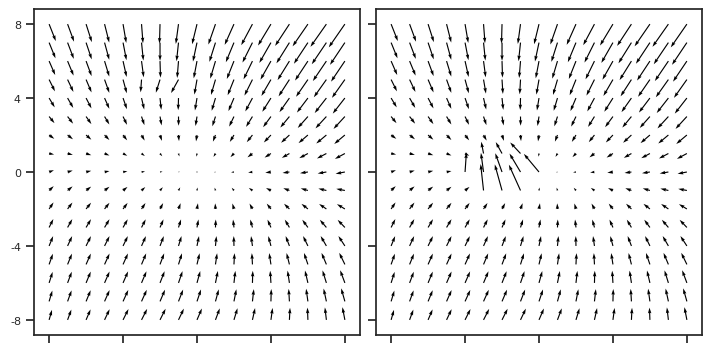

In [9]:
sample_i = 2
show_opticflow(
    np.stack([
        rofl.alpha_dot[sample_i],
        rofl_new.alpha_dot[sample_i]]),
    num=2,
    scale=5,
);

In [10]:
rofl.v_slf[sample_i]

array([-0.12309237, -0.49621795,  0.07369505])

In [11]:
rofl.objects[0].v[sample_i]

array([-0.26399746,  0.55249258,  0.20054976])

In [12]:
rofl.objects[0].size[sample_i]

0.010380622837370243

In [13]:
rofl_new.objects[0].size[sample_i]

0.03806228373702422

In [14]:
sp_stats.pearsonr(rofl_new.objects[0].pos[:, 1], rofl_new.fix[:, 1])

(0.9792209541389734, 0.0)

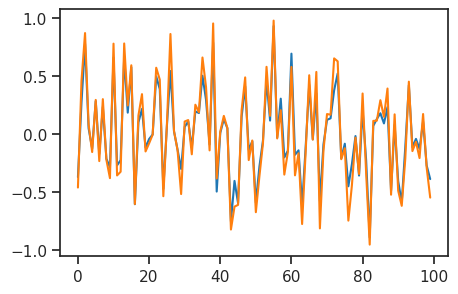

In [15]:
plt.plot(rofl_new.objects[0].pos[:, 1][:100])
plt.plot(rofl_new.fix[:, 1][:100]);

## Take that sample and explore

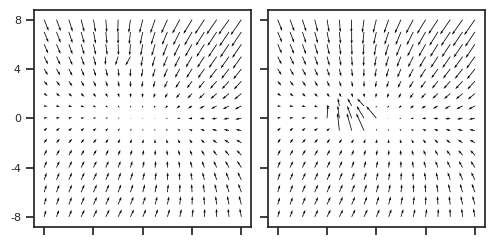

In [16]:
sample_i = 2
show_opticflow(
    np.stack([
        rofl.alpha_dot[sample_i],
        rofl_new.alpha_dot[sample_i]]),
    num=3,
    scale=5,
);

In [17]:
attrs_slf = {
    k: np.repeat(
        getattr(rofl, k)[[sample_i]],
        repeats=rofl.dim,
        axis=0,
    ) for k in ['fix', 'v_slf']
}
alpha = np.repeat(
    rofl.objects[0].alpha[[sample_i]],
    repeats=rofl.dim, axis=0)
alpha[:, 1] = rofl.span
attrs_obj = {0: {
    'alpha': alpha,
    'v_obj': np.repeat(
        rofl.objects[0].v[[sample_i]],
        repeats=rofl.dim, axis=0),
    'z': [rofl.objects[0].pos[sample_i, 2]] * rofl.dim,
}}
rofl3 = ROFL(n=rofl.n, **kws)
rofl3.setattrs(attrs_slf, attrs_obj)
_ = rofl3.compute_flow()

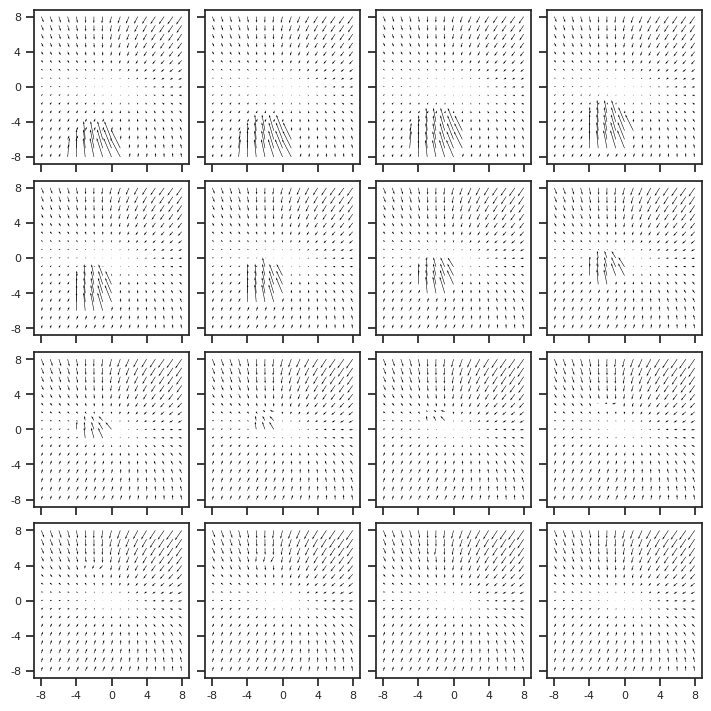

In [18]:
show_opticflow(rofl3.alpha_dot);

### Turn off self motion

In [19]:
attrs_slf['v_slf'] = np.zeros_like(attrs_slf['v_slf'])
rofl4 = ROFL(n=rofl.n, **kws)
rofl4.setattrs(attrs_slf, attrs_obj)
_ = rofl4.compute_flow()

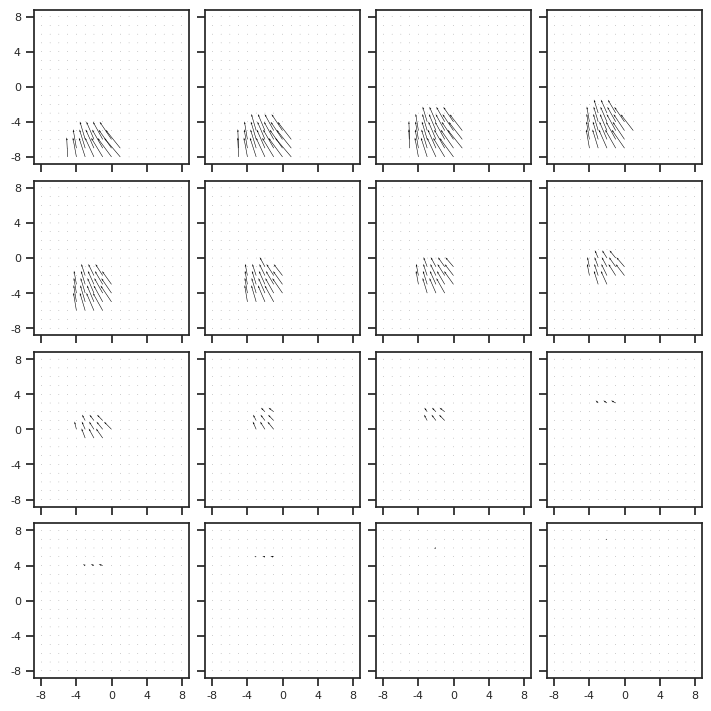

In [20]:
show_opticflow(rofl4.alpha_dot, scale=5);

In [21]:
rofl4.objects[0].size

array([0.05882353, 0.08304498, 0.10034602, 0.08304498, 0.07612457,
       0.06920415, 0.05882353, 0.05190311, 0.03806228, 0.02768166,
       0.02076125, 0.01038062, 0.01038062, 0.01038062, 0.00346021,
       0.00346021, 0.00346021])

### Turn off fixation

In [22]:
attrs_slf['fix'] = np.zeros_like(attrs_slf['fix'])
rofl5 = ROFL(n=rofl.n, **kws)
rofl5.setattrs(attrs_slf, attrs_obj)
_ = rofl5.compute_flow()

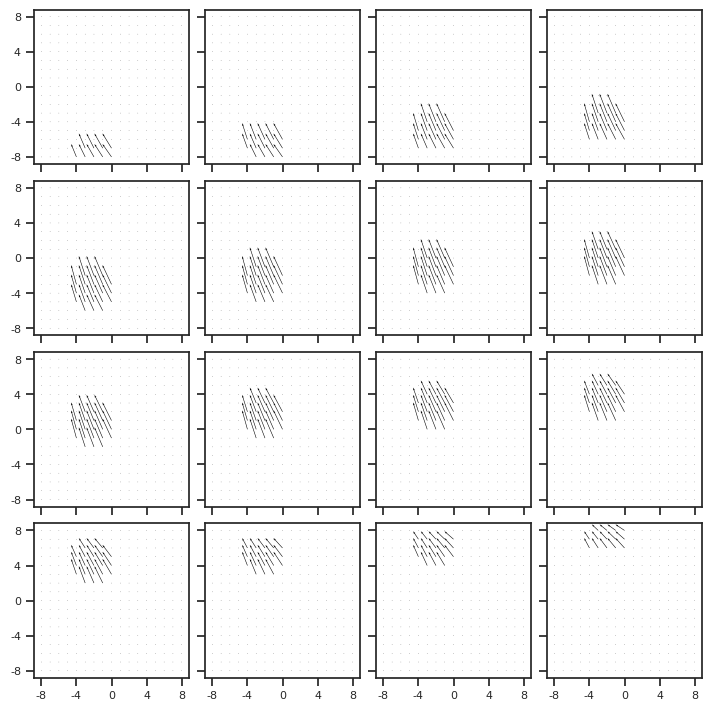

In [23]:
show_opticflow(rofl5.alpha_dot, scale=5);

In [24]:
rofl5.objects[0].size

array([0.03114187, 0.04844291, 0.06228374, 0.06228374, 0.07266436,
       0.07266436, 0.07266436, 0.07266436, 0.07266436, 0.07266436,
       0.07266436, 0.07266436, 0.07266436, 0.06228374, 0.06228374,
       0.04844291, 0.03114187])

## Factors: switched obj z with obj distance

In [27]:
f, g, f_aux, g_aux = rofl4.groundtruth_factors()

/home/hadi/Dropbox/git/_MTMST/analysis/helper.py:262: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(x[:, 2] / r)


In [52]:
g.shape

(17, 11)

In [53]:
for i, lbl in enumerate(f):
    print(f"f = {lbl}\ng = {g[:, i]}\n")

f = fix_x
g = [0.08724998 0.08724998 0.08724998 0.08724998 0.08724998 0.08724998
 0.08724998 0.08724998 0.08724998 0.08724998 0.08724998 0.08724998
 0.08724998 0.08724998 0.08724998 0.08724998 0.08724998]

f = fix_y
g = [0.87014485 0.87014485 0.87014485 0.87014485 0.87014485 0.87014485
 0.87014485 0.87014485 0.87014485 0.87014485 0.87014485 0.87014485
 0.87014485 0.87014485 0.87014485 0.87014485 0.87014485]

f = slf_v_norm
g = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

f = slf_v_theta
g =

f = slf_v_phi
g = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

f = obj0_alpha_x
g = [-0.19634954 -0.19634954 -0.19634954 -0.19634954 -0.19634954 -0.19634954
 -0.19634954 -0.19634954 -0.19634954 -0.19634954 -0.19634954 -0.19634954
 -0.19634954 -0.19634954 -0.19634954 -0.19634954 -0.19634954]

f = obj0_alpha_y
g = [-0.78539816 -0.68722339 -0.58904862 -0.49087385 -0.39269908 -0.29452431
 -0.19634954 -0.09817477  0.          0.09817477  0.19634954  0.29452431
  0.39269908  0.49087385  0.58904862  0.68722339  0.78539816]

f = obj0_z
g = [0.9017425 0.9017425 0.9017425 0.9017425 0.9017425 0.9017425 0.9017425
 0.9017425 0.9017425 0.9017425 0.9017425 0.9017425 0.9017425 0.9017425
 0.9017425 0.9017425 0.9017425]

f = obj0_v_norm
g = [0.64433137 0.64433137 0.64433137 0.64433137 0.64433137 0.64433137
 0.64433137 0.64433137 0.64433137 0.64433137 0.64433137 0.64433137
 0.64433137 0.64433137 0.64433137 0.64433137 0.64433137]

f = obj0_v_theta
g = [1.25428559 1.25428559 1.25428559 1.25428559 1.25428559 1.25428559
 1.25428559 1.25428559 1.25428559 1.25428559 1.25428559 1.25428559
 1.25428559 1.25428559 1.25428559 1.25428559 1.25428559]

f = obj0_v_phi
g = [2.01655106 2.01655106 2.01655106 2.01655106 2.01655106 2.01655106
 2.01655106 2.01655106 2.01655106 2.01655106 2.01655106 2.01655106
 2.01655106 2.01655106 2.01655106 2.01655106 2.01655106]